<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/DLThon/dlthon_jellyfish_recap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

Moon_jellyfish_folder = ROOT_PATH + "/jellyfish/Moon_jellyfish"
barrel_jellyfish_folder = ROOT_PATH + "/jellyfish/barrel_jellyfish"
blue_jellyfish_folder = ROOT_PATH + "/jellyfish/blue_jellyfish"
compass_jellyfish_folder = ROOT_PATH + "/jellyfish/compass_jellyfish"
lions_mane_jellyfish_folder = ROOT_PATH + "/jellyfish/lions_mane_jellyfish"
mauve_stinger_jellyfish_folder = ROOT_PATH + "/jellyfish/mauve_stinger_jellyfish"

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return images

Moon_images = load_images_from_folder(Moon_jellyfish_folder)
barrel_images = load_images_from_folder(barrel_jellyfish_folder)
blue_images = load_images_from_folder(blue_jellyfish_folder)
compass_images = load_images_from_folder(compass_jellyfish_folder)
lions_mane_images = load_images_from_folder(lions_mane_jellyfish_folder)
mauve_stinger_images = load_images_from_folder(mauve_stinger_jellyfish_folder)

Moon_labels = [0] * len(Moon_images)
barrel_labels = [1] * len(barrel_images)
blue_labels = [2] * len(blue_images)
compass_labels = [3] * len(compass_images)
lions_mane_labels = [4] * len(lions_mane_images)
mauve_stinger_labels = [5] * len(mauve_stinger_images)

all_labels = Moon_labels+barrel_labels+blue_labels+compass_labels+lions_mane_labels+mauve_stinger_labels

In [ ]:
print('Moon_jellyfish_images: ',len(Moon_images))
print('barrel_jellyfish_images: ',len(barrel_images))
print('blue_jellyfish_images: ',len(blue_images))
print('compass_jellyfish_images: ',len(compass_images))
print('lions_mane_jellyfish_images: ',len(lions_mane_images))
print('mauve_stinger_jellyfish_images: ',len(mauve_stinger_images))

Moon_jellyfish_images:  150
barrel_jellyfish_images:  150
blue_jellyfish_images:  150
compass_jellyfish_images:  150
lions_mane_jellyfish_images:  150
mauve_stinger_jellyfish_images:  150


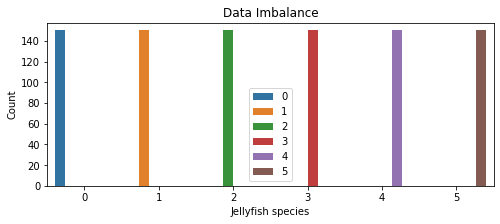

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 3))
sns.countplot(x=all_labels, hue=all_labels)
plt.title('Data Imbalance')
plt.xlabel('Jellyfish species')
plt.ylabel('Count')
plt.show()

In [ ]:
X = np.array(Moon_images + barrel_images + blue_images + compass_images + lions_mane_images + mauve_stinger_images)
y = np.array(Moon_labels + barrel_labels + blue_labels + compass_labels + lions_mane_labels + mauve_stinger_labels)

X = X.astype('float32') / 255.0

# 레이블 원핫-인코딩
y = np_utils.to_categorical(y, 6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [ ]:
input_shape_resnet = (224, 224, 3)
input_shape_densenet = (224, 224, 3)
input_shape_efficientnet = (224, 224, 3)

def resize_images(images, input_shape):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, (input_shape[0], input_shape[1]))
        img_resized = np.expand_dims(img_resized, axis=-1)
        img_resized = np.repeat(img_resized, 3, axis=-1)
        resized_images.append(img_resized)
    return np.array(resized_images)

X_train_resized_resnet = resize_images(X_train, input_shape_resnet)

X_train_resized_densenet = resize_images(X_train, input_shape_densenet)

X_train_resized_efficientnet = resize_images(X_train, input_shape_efficientnet)

In [ ]:
def resnet_block(inputs, filters, strides=1, activation=tf.nn.relu):

    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation(x)


    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides > 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = tf.keras.layers.add([x, shortcut])
    x = activation(x)

    return x

def resnet18(input_shape=input_shape_resnet, num_classes=6):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, x)

    return model

resnet_model = resnet18()

resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# DenseNet121
densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape_densenet)
densenet_base_model.trainable = False

densenet_global_avg_pooling = GlobalAveragePooling2D()(densenet_base_model.output)
densenet_output = Dense(6, activation='softmax')(densenet_global_avg_pooling)
densenet_model = Model(inputs=densenet_base_model.input, outputs=densenet_output)

densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
# ResNet18
resnet_history = resnet_model.fit(
                                    X_train_resized_resnet,
                                    y_train, batch_size=10,
                                    epochs=50,
                                    validation_split=0.2,
                                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
58/58 [==============================] - 11s 70ms/step - loss: 2.7374 - accuracy: 0.2049 - val_loss: 35.8011 - val_accuracy: 0.1944
Epoch 2/50
58/58 [==============================] - 3s 49ms/step - loss: 1.8042 - accuracy: 0.2969 - val_loss: 5.5371 - val_accuracy: 0.1875
Epoch 3/50
58/58 [==============================] - 3s 49ms/step - loss: 1.6605 - accuracy: 0.3316 - val_loss: 3.3280 - val_accuracy: 0.1111
Epoch 4/50
58/58 [==============================] - 3s 49ms/step - loss: 1.6825 - accuracy: 0.3472 - val_loss: 2.2133 - val_accuracy: 0.2708
Epoch 5/50
58/58 [==============================] - 3s 49ms/step - loss: 1.6350 - accuracy: 0.3663 - val_loss: 3.8368 - val_accuracy: 0.2500
Epoch 6/50
58/58 [==============================] - 3s 49ms/step - loss: 1.6123 - accuracy: 0.3698 - val_loss: 1.8463 - val_accuracy: 0.3125
Epoch 7/50
58/58 [==============================] - 3s 49ms/step - loss: 1.5199 - accuracy: 0.4271 - val_loss: 11.3254 - val_accuracy: 0.2153
Epoch 8/50

In [ ]:
# DenseNet121
densenet_history = densenet_model.fit(
                                    X_train_resized_densenet,
                                    y_train, batch_size=10,
                                    epochs=50,
                                    validation_split=0.2,
                                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
58/58 [==============================] - 7s 58ms/step - loss: 0.7598 - accuracy: 0.7535 - val_loss: 0.7162 - val_accuracy: 0.7639
Epoch 2/50
58/58 [==============================] - 2s 41ms/step - loss: 0.5345 - accuracy: 0.8247 - val_loss: 0.6420 - val_accuracy: 0.7847
Epoch 3/50
58/58 [==============================] - 2s 40ms/step - loss: 0.4460 - accuracy: 0.8698 - val_loss: 0.6024 - val_accuracy: 0.8125
Epoch 4/50
58/58 [==============================] - 2s 40ms/step - loss: 0.3571 - accuracy: 0.9080 - val_loss: 0.5296 - val_accuracy: 0.8333
Epoch 5/50
58/58 [==============================] - 2s 41ms/step - loss: 0.3056 - accuracy: 0.9323 - val_loss: 0.4767 - val_accuracy: 0.8403
Epoch 6/50
58/58 [==============================] - 2s 41ms/step - loss: 0.2796 - accuracy: 0.9253 - val_loss: 0.4576 - val_accuracy: 0.8681
Epoch 7/50
58/58 [==============================] - 2s 40ms/step - loss: 0.2445 - accuracy: 0.9444 - val_loss: 0.3901 - val_accuracy: 0.8611
Epoch 8/50
58

In [ ]:
# EfficientNetB0
efficientnet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape_efficientnet)
efficientnet_base_model.trainable = False

efficientnet_global_avg_pooling = GlobalAveragePooling2D()(efficientnet_base_model.output)
efficientnet_output = Dense(6, activation='softmax')(efficientnet_global_avg_pooling)
efficientnet_model = Model(inputs=efficientnet_base_model.input, outputs=efficientnet_output)

efficientnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(
                                    X_train_resized_efficientnet,
                                    y_train, batch_size=10,
                                    epochs=50,
                                    validation_split=0.2,
                                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
58/58 [==============================] - 11s 93ms/step - loss: 1.4705 - accuracy: 0.4566 - val_loss: 1.0423 - val_accuracy: 0.6667
Epoch 2/50
58/58 [==============================] - 2s 41ms/step - loss: 0.8482 - accuracy: 0.7205 - val_loss: 0.7745 - val_accuracy: 0.7500
Epoch 3/50
58/58 [==============================] - 2s 42ms/step - loss: 0.6127 - accuracy: 0.8021 - val_loss: 0.6352 - val_accuracy: 0.7917
Epoch 4/50
58/58 [==============================] - 2s 42ms/step - loss: 0.4997 - accuracy: 0.8490 - val_loss: 0.5581 - val_accuracy: 0.8194
Epoch 5/50
58/58 [==============================] - 2s 42ms/step - loss: 0.4174 - accuracy: 0.8837 - val_loss: 0.5141 - val_accuracy: 0.8194
Epoch 6/50
58/58 [==============================] - 2s 41ms/step - loss: 0.3583 - accuracy: 0.8976 - val_loss: 0.5087 - val_accuracy: 0.8264
Epoch 7/50
58/58 [==============================] - 2s 42ms/step - loss: 0.3143 - accuracy: 0.9219 - val_loss: 0.4737 - val_accuracy: 0.8542
Epoch 8/50
5

In [ ]:
X_test_resized_resnet = resize_images(X_test, input_shape_resnet)
X_test_resized_densenet = resize_images(X_test, input_shape_densenet)
X_test_resized_efficientnet = resize_images(X_test, input_shape_efficientnet)

resnet_loss, resnet_accuracy = resnet_model.evaluate(X_test_resized_resnet, y_test)
densenet_loss, densenet_accuracy = densenet_model.evaluate(X_test_resized_densenet, y_test)
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(X_test_resized_efficientnet, y_test)

print("ResNet18 Test accuracy:", resnet_accuracy)
print("DenseNet121 Test accuracy:", densenet_accuracy)
print("EfficientNetB0 Test accuracy:", efficientnet_accuracy)

6/6 [==============================] - 1s 85ms/step - loss: 0.1551 - accuracy: 0.9667
ResNet18 Test accuracy: 0.4333333373069763
DenseNet121 Test accuracy: 0.949999988079071
EfficientNetB0 Test accuracy: 0.9666666388511658


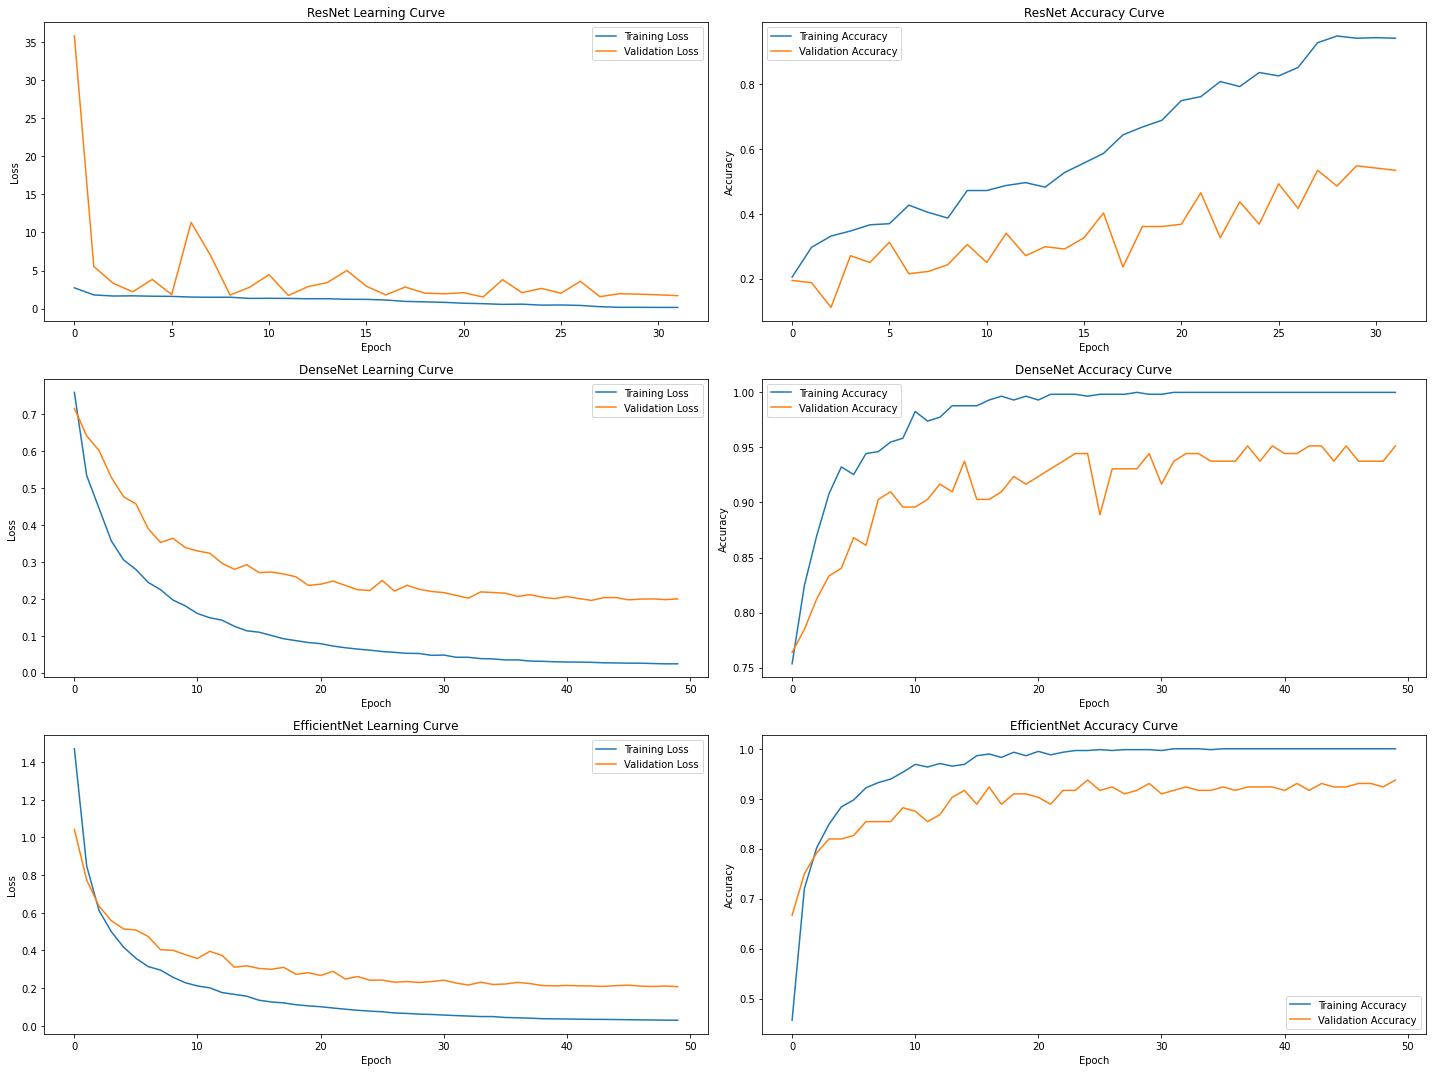

In [ ]:
def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()


def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axs = plt.subplots(3, 2, figsize=(20, 15))

plot_learning_curves(resnet_history, 'ResNet', axs[0, 0])
plot_accuracy_curves(resnet_history, 'ResNet', axs[0, 1])

plot_learning_curves(densenet_history, 'DenseNet', axs[1, 0])
plot_accuracy_curves(densenet_history, 'DenseNet', axs[1, 1])

plot_learning_curves(efficientnet_history, 'EfficientNet', axs[2, 0])
plot_accuracy_curves(efficientnet_history, 'EfficientNet', axs[2, 1])


plt.tight_layout()
plt.show()